# Voice-Analysis-Driven Machine Learning: A Contemporary Approach for Parkinson's Disease Diagnosis

## Abstract

This study compares classical and contemporary machine-learning techniques for Parkinson's Disease (PD) diagnosis using voice recordings obtained from the University of Oxford dataset available at https://www.kaggle.com/datasets/yasserhessein/parkinsons. We employ various models including SVM, XGBoost, KNN, Decision Trees, Random Forest, Logistic Regression, and an optimized Deep Learning model — a customized multilayer perceptron (MLP) — tuned via Bayesian Optimization (BO). The results of the models show that BO significantly enhances the deep-learning model's performance with a test accuracy of 96.92%, and minimal overfitting. Other models also demonstrated high accuracy, with Random Forest and XGBoost, both tuned via RandomSearchCV, surpassing 90%. These results highlight the potential of machine learning and voice analysis in non-invasive PD diagnostics for early detection and monitoring of the disease.

## Keywords: *Bayesian Optimization, Deep Learning, Machine Learning, Multilayer Perceptron, Parkinson's Disease Diagnosis, Voice Analysis.*

## I. Introduction

The early diagnosis of Parkinson's Disease (PD), a progressive neurological disorder, remains a critical challenge in the medical field. Recent advancements in machine learning offer promising avenues for developing non-invasive diagnostic tools. This study focuses on adapting these technologies, specifically deep learning and voice analysis, to differentiate individuals with PD from healthy subjects. Using a dataset comprising voice recordings from patients with and without PD, we employ a range of machine learning models, including a custom-designed Multilayer Perceptron (MLP), optimized through Bayesian techniques. Our approach centers on analyzing subtle voice characteristics altered by PD, leveraging neural networks' ability to discern complex patterns in data. By exploring the potential of machine learning in medical diagnostics, this study aims to contribute to the early and accurate detection of Parkinson's Disease, offering significant implications for patient care and treatment planning.

In what follows, we discuss the methodology, including why certain design elements were chosen, the dataset, and the results obtained. We conclude with a brief discussion of possible avenues for future research.

## II. Methodology

The deep learning model in this project, referred to as EnhancedNet, is a type of Multilayer Perceptron (MLP). It operates on the principle of feedforward neural networks where information moves in only one direction — from input nodes, through hidden layers, to output nodes. The core functionality of each layer in EnhancedNet can be mathematically represented as $$ y = f(Wx + b) $$ Here, $ x $ represents the input to the layer, $ W $ is the weight matrix associated with the layer, $ b $ is the bias, and $ f $ denotes the activation function, in this case, ReLU (Rectified Linear Unit), defined as $$ f(z) = \max(0, z) $$ ReLU introduces non-linearity, enabling the network to learn complex patterns. EnhancedNet also incorporates dropout layers to prevent overfitting, functioning through the equation $$ y = x \odot m $$ where $ m $ is a mask vector with elements drawn from a Bernoulli distribution, randomly zeroing some of the elements of the input vector $ x $. The network's loss is computed using the Cross-Entropy Loss function, given by $$ L = -\sum_{i} y_i \log(p_i) $$ with $ y_i $ being the true label and $ p_i $ the predicted probability of the class. This architecture allows EnhancedNet to effectively learn from the voice data for PD diagnosis.

### Bayesian Optimization Overview

Bayesian Optimization in this project is used for hyperparameter tuning of EnhancedNet. This technique models the objective function $ f(x) $ (the model's accuracy in our case) as a Gaussian process, providing a probabilistic estimate of the function's behavior. For a set of hyperparameters $ x $, the goal is to find the set that maximizes $ f(x) $. The optimization process involves choosing new hyperparameters to evaluate by maximizing an acquisition function, which in this study, can be the Expected Improvement (EI). The EI is computed as $$ EI(x) = \mathbb{E}[\max(f(x) - f(x^+), 0)] $$ where $ f(x^+) $ is the best objective function value observed hitherto. Bayesian Optimization iteratively updates its model of the objective function based on the performance of the deep learning model with the selected hyperparameters, leading to more informed and effective choices of hyperparameters in successive iterations. This method provides a systematic approach to navigate the hyperparameter space and is particularly useful for optimizing complex models like EnhancedNet, where manual tuning is infeasible.


### A. Install packages

In [1]:
!pip install bayesian-optimization

### B. Import libraries and modules

We utilize a range of libraries and modules to facilitate a comprehensive machine learning pipeline for diagnosing Parkinson's Disease using voice data. PyTorch, with its intuitive and flexible nature, has gained favor in recent times. It offers dynamic computation graphs, essential neural network building blocks through `torch.nn`, and a variety of optimization algorithms in `torch.optim`. Data handling and preprocessing are managed using NumPy and Pandas. Feature scaling is performed using Scikit-learn's `MinMaxScaler`, and the class imbalance in the dataset is addressed using the `SMOTE` algorithm. For model selection and evaluation, we employ Scikit-learn's tools like `train_test_split`, `RandomizedSearchCV`, `KFold`, and various metrics like accuracy score and ROC-AUC. A range of traditional machine learning models, including SVM, XGBoost, KNN, Decision Trees, Random Forest, and Logistic Regression, are explored alongside deep learning models. Visualization of data and results is achieved through Matplotlib and Seaborn. Additionally, Bayesian Optimization is used to fine-tune the hyperparameters of models.

In [11]:
# Deep Learning with PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Data Preprocessing and Augmentation
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score

# Machine Learning Models
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Bayesian Optimization
from bayes_opt import BayesianOptimization


### C. Load dataset

We use Google Colab for its ease of use and computational prowess vis-a-vis its GPUs.

The dataset central to this study was developed by Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech in Denver, Colorado. It focuses on biomedical voice measurements for the purpose of distinguishing individuals with Parkinson's Disease (PD) from healthy individuals. The dataset encompasses 195 voice recordings from 31 participants, out of whom 23 are diagnosed with PD. Each recording is represented by a row in the dataset, with various columns detailing specific voice measures. These measures include fundamental frequency attributes (MDVP:Fo, MDVP:Fhi, MDVP:Flo), various measures of frequency and amplitude variations (MDVP:Jitter, MDVP:Shimmer, etc.), and other significant features like the noise-to-harmonics ratio (NHR, HNR) and nonlinear dynamical complexity measures (RPDE, D2, DFA, spread1, spread2, PPE). The dataset, formatted in ASCII CSV, also labels each instance with a binary 'status' indicating whether the subject is healthy or has PD. This comprehensive collection of voice attributes provides a rich basis for applying machine learning techniques to identify potential PD biomarkers in speech patterns. Researchers using this dataset are encouraged to cite the work of Little et al. (2008) in "Suitability of dysphonia measurements for telemonitoring of Parkinson's disease," which elaborates on the feature extraction methods for voice disorders.

In [3]:
from google.colab import files
import pandas as pd

# Upload the CSV file
uploaded = files.upload()

# Reading the uploaded CSV file
for filename in uploaded.keys():
    df = pd.read_csv(filename)
    print(f"Uploaded file '{filename}'")
    # Now you can use 'df' as your DataFrame for further operations

Saving parkinsons.csv to parkinsons (1).csv
Uploaded file 'parkinsons (1).csv'


### D. Useful functions

In [4]:
# Function to plot Confusion Matrix and ROC-AUC Curve
def plot_metrics(model, X_test, y_test, model_name, is_deep_learning=False):
    """
    Plots the Confusion Matrix and ROC-AUC Curve for a given model.

    This function takes a trained model, test data, and labels, then computes and plots the Confusion Matrix and ROC-AUC Curve. It supports both traditional machine learning models and deep learning models.

    Parameters:
    model (model object): The trained model (can be either a scikit-learn model or a PyTorch model).
    X_test (array-like): Test features to be used for making predictions.
    y_test (array-like): True labels for X_test.
    model_name (str): The name of the model, used for titling the plots.
    is_deep_learning (bool, optional): Flag to indicate if the model is a deep learning model. Default is False.

    Returns:
    None: The function doesn't return anything but plots the Confusion Matrix and ROC-AUC Curve.
    """
    if is_deep_learning:
        with torch.no_grad():
            outputs = model(torch.tensor(X_test, dtype=torch.float32))
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1].numpy()
            predictions = torch.max(outputs.data, 1)[1].numpy()
    else:
        probabilities = model.predict_proba(X_test)[:, 1]
        predictions = model.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = roc_auc_score(y_test, probabilities)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve: {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Function to train and evaluate the model
def train_eval_model(model, X_train, y_train, X_test, y_test, params=None, is_deep_learning=False):
    """
    Trains and evaluates a machine learning model, supporting both traditional and deep learning models.

    This function handles the training process for the provided model on the training dataset and then evaluates it on both the training and testing datasets. It supports hyperparameter tuning for deep learning models and utilizes appropriate evaluation metrics to gauge performance.

    Parameters:
    model (model object): The machine learning model to be trained and evaluated.
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Testing features used for evaluating the model.
    y_test (array-like): True labels for X_test.
    params (dict, optional): Hyperparameters for training deep learning models. Required if is_deep_learning is True.
    is_deep_learning (bool, optional): Flag to indicate if the model is a deep learning model. Default is False.

    Returns:
    tuple: A tuple containing train_accuracy and test_accuracy in percentage.
    """
    if is_deep_learning:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
        train_loader = DataLoader(train_dataset, batch_size=int(params['batch_size']), shuffle=True)

        model.train()
        for epoch in range(int(params['epochs'])):
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            outputs = model(torch.tensor(X_test, dtype=torch.float32))
            _, predicted = torch.max(outputs.data, 1)
            test_accuracy = accuracy_score(y_test, predicted.numpy()) * 100
            train_accuracy = accuracy_score(y_train, model(torch.tensor(X_train, dtype=torch.float32)).max(1)[1].numpy()) * 100
        return train_accuracy, test_accuracy
    else:
        model.fit(X_train, y_train)
        train_accuracy = model.score(X_train, y_train) * 100
        test_accuracy = model.score(X_test, y_test) * 100
        return train_accuracy, test_accuracy

# Function to optimize deep learning model using Bayesian Optimization
def optimize_dl_model(X_train, y_train, X_test, y_test):
    """
    Optimizes hyperparameters of a deep learning model using Bayesian Optimization.

    This function seeks to find the best combination of learning rate, batch size, and number of epochs for a deep learning model, aimed at maximizing test accuracy. It uses Bayesian Optimization, an efficient method for optimizing hyperparameters in a defined range.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Testing features.
    y_test (array-like): Testing labels.

    Returns:
    dict: A dictionary containing the optimized hyperparameters 'lr' (learning rate), 'batch_size', and 'epochs'.
    """
    def objective(lr, batch_size, epochs):
        # Adjust the hyperparameters
        params = {
            'lr': lr,
            'batch_size': int(batch_size),
            'epochs': int(epochs)
        }
        # Train and evaluate the model
        _, test_accuracy = train_eval_model(models['Deep Learning'], X_train, y_train, X_test, y_test, params, is_deep_learning=True)
        return test_accuracy

    # Refined Parameter bounds
    pbounds = {
        'lr': (1e-4, 1e-2),
        'batch_size': (16, 64),
        'epochs': (20, 100)
    }

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize(
        init_points=2,
        n_iter=30,  # Increased number of iterations
    )

    return optimizer.max['params']


### E. Data preprocessing and augmentation

In [5]:
# Get the features and labels
X = df.loc[:, df.columns != 'status'].values[:, 1:]
y = df.loc[:, 'status'].values

# Scale the features
scaler = MinMaxScaler((-1, 1))
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y)

# Apply SMOTE for data augmentation
smote = SMOTE(random_state=1)
X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

### F. Machine-Learning models

In [6]:
# EnhancedNet definition with Dropout
class EnhancedNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EnhancedNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

In [7]:
# Define models and their hyperparameters
models = {
    "SVM": SVC(probability=True),
    "XGBoost": xgb.XGBClassifier(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Deep Learning": EnhancedNet(X_train.shape[1], 100, 2)  # Example: Assuming X_train is defined
}


### G. Hyperparameters

In [8]:
# Modify hyperparameter spaces or reduce n_iter in RandomizedSearchCV if needed
param_distributions = {
    "SVM": {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf']},
    "XGBoost": {'max_depth': [3, 5, 7], 'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2]},
    "KNN": {'n_neighbors': [3, 5, 7, 10]},
    "Decision Tree": {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    "Random Forest": {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]},
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
}

# Hyperparameters for deep learning model
deep_learning_params = {'lr': 0.001, 'batch_size': 32, 'epochs': 100}

# K-Fold Cross-Validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=1)

### H. Training, Evaluation, Visualization

Optimizing Deep Learning model...
|   iter    |  target   | batch_... |  epochs   |    lr     |
-------------------------------------------------------------
| 1         | 79.49     | 36.02     | 77.63     | 0.0001011 |
| 2         | 84.62     | 30.51     | 31.74     | 0.001014  |
| 3         | 84.62     | 29.71     | 32.75     | 0.008661  |
| 4         | 84.62     | 64.0      | 20.0      | 0.01      |
| 5         | 84.62     | 16.03     | 20.59     | 0.008572  |
| 6         | 84.62     | 64.0      | 44.24     | 0.01      |
| 7         | 87.18     | 64.0      | 100.0     | 0.01      |
| 8         | 87.18     | 64.0      | 85.85     | 0.01      |
| 9         | 84.62     | 64.0      | 68.78     | 0.01      |
| 10        | 84.62     | 52.27     | 100.0     | 0.0001    |
| 11        | 82.05     | 64.0      | 92.96     | 0.01      |
| 12        | 82.05     | 64.0      | 82.96     | 0.009775  |
| 13        | 87.18     | 63.03     | 99.46     | 0.001681  |
| 14        | 87.18     | 63.53     

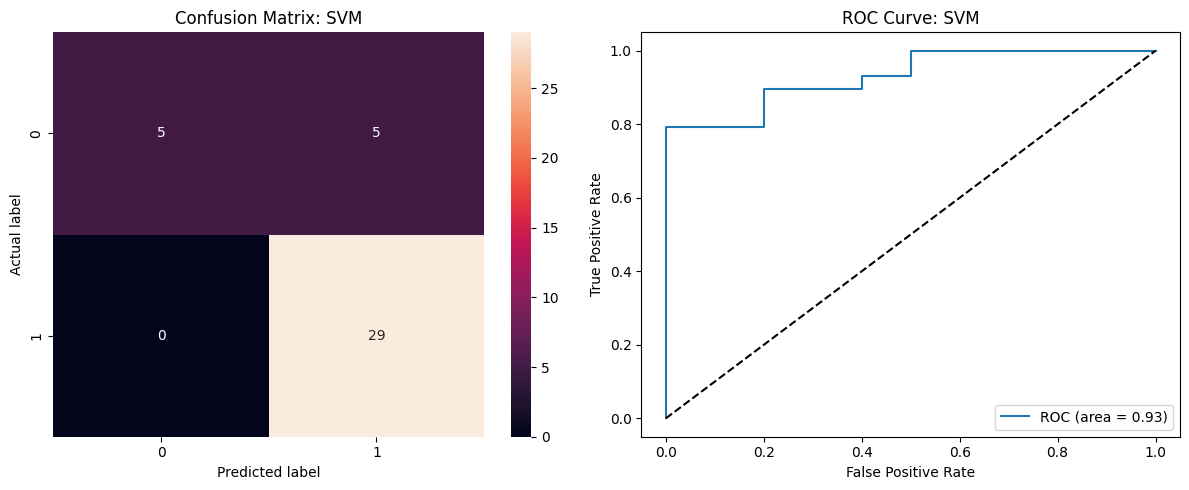

XGBoost: Train accuracy: 100.00%, Test accuracy: 91.79%


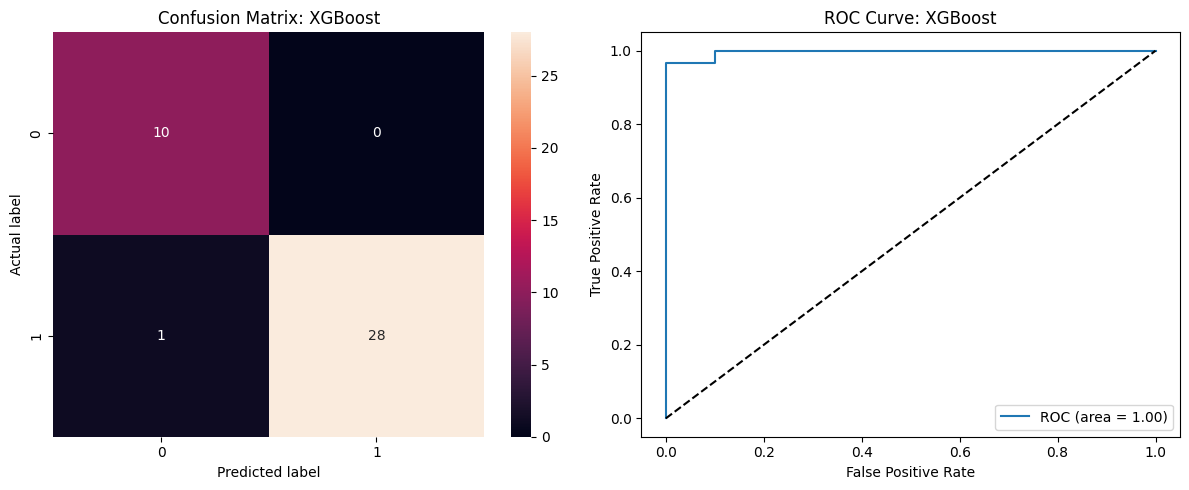

KNN: Train accuracy: 92.44%, Test accuracy: 89.23%


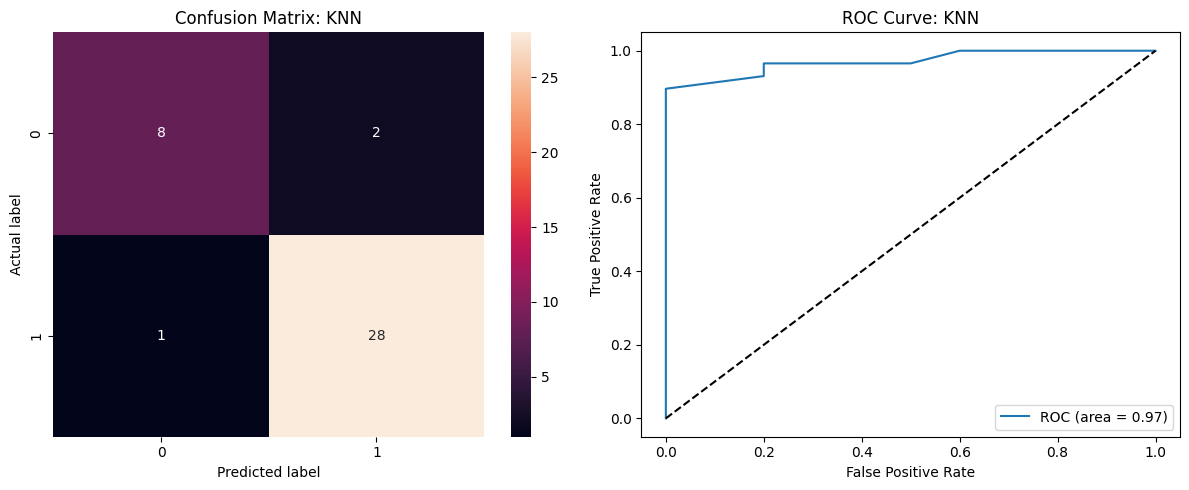

Decision Tree: Train accuracy: 99.49%, Test accuracy: 84.10%


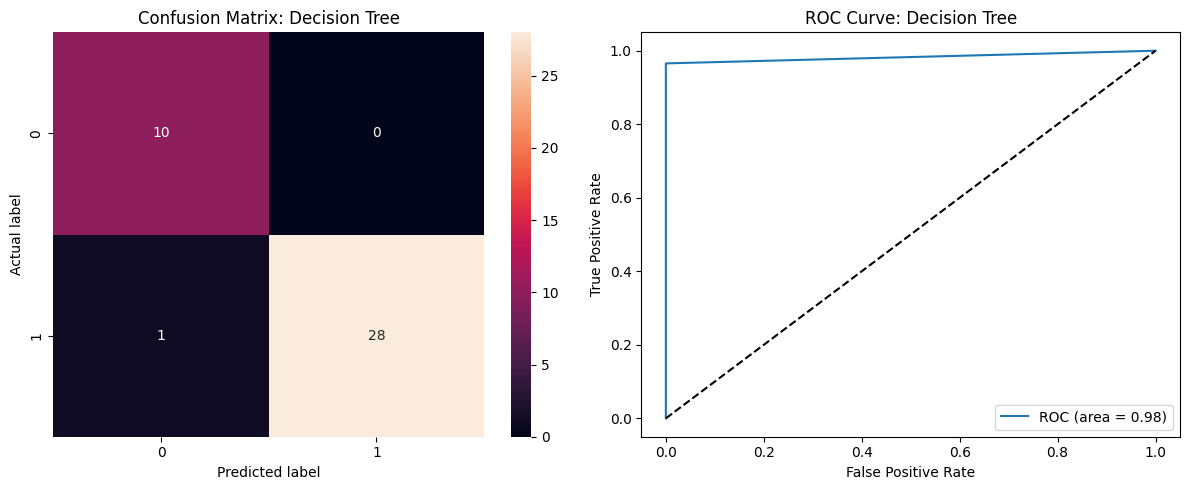

Random Forest: Train accuracy: 100.00%, Test accuracy: 92.31%


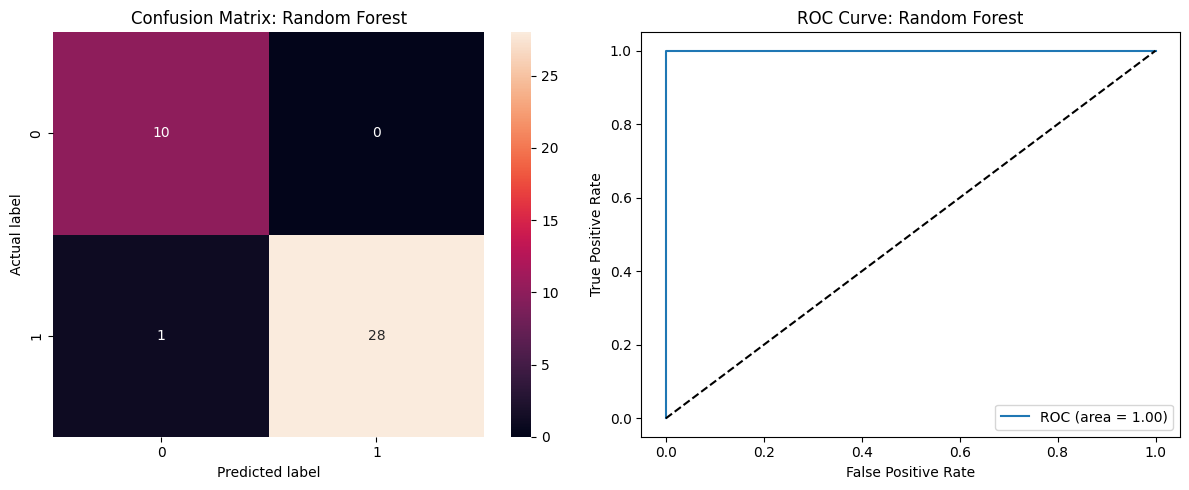

Logistic Regression: Train accuracy: 85.38%, Test accuracy: 84.62%


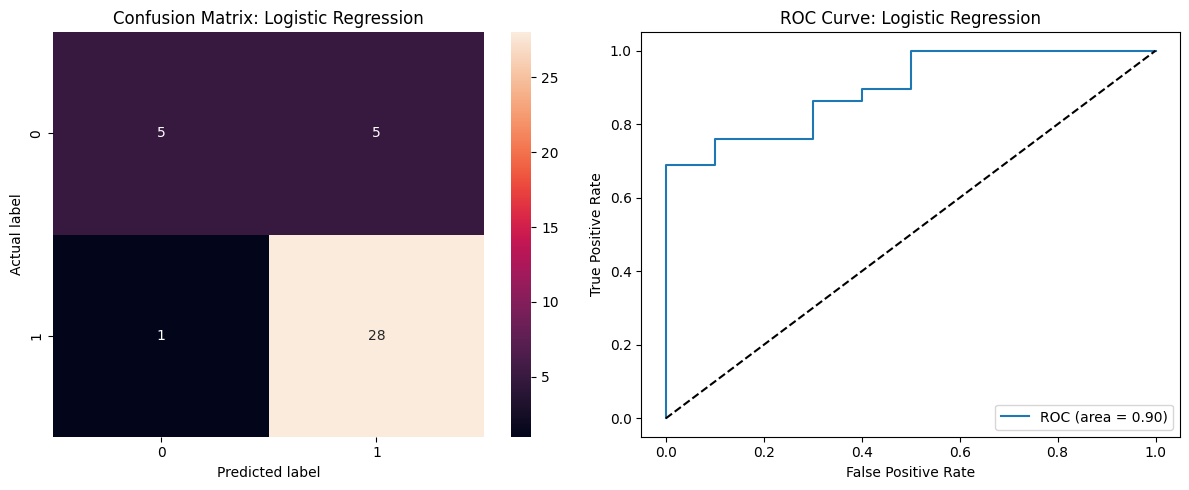

Deep Learning: Train accuracy: 99.36%, Test accuracy: 96.92%


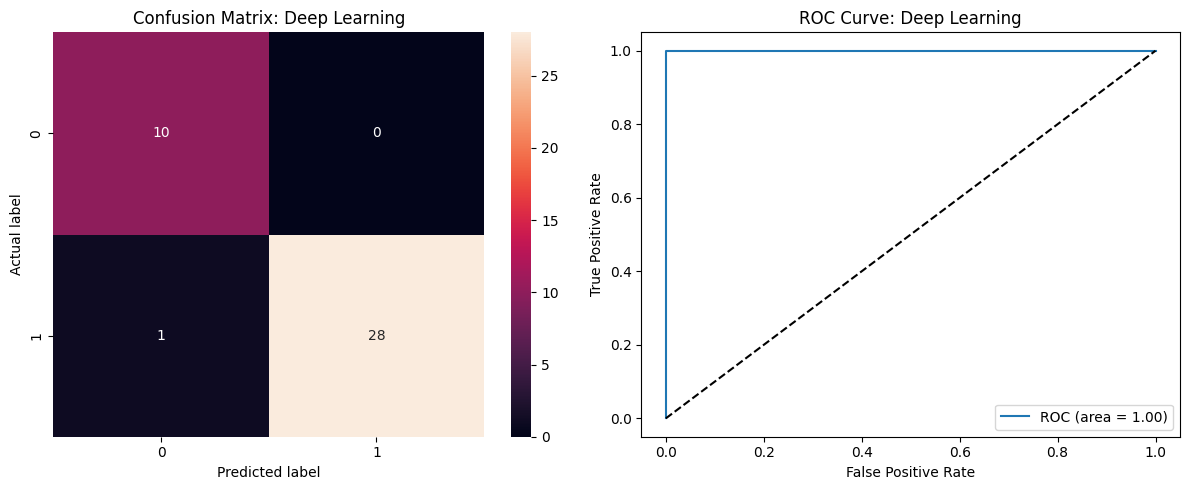

In [9]:
# Store model accuracies
model_accuracies = {}

# First, optimize the Deep Learning model using Bayesian Optimization
if "Deep Learning" in models:
    print("Optimizing Deep Learning model...")
    optimized_params = optimize_dl_model(X_train, y_train, X_test, y_test)
    print(f'Optimized Parameters: {optimized_params}')
    deep_learning_params['lr'] = optimized_params['lr']
    deep_learning_params['batch_size'] = int(optimized_params['batch_size'])
    deep_learning_params['epochs'] = int(optimized_params['epochs'])

for model_name, model in models.items():
    accuracies = []
    train_accuracies = []
    for train_index, test_index in kf.split(X_scaled):
        X_train_kf, X_test_kf = X_scaled[train_index], X_scaled[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]

        # Train and evaluate model
        if model_name != "Deep Learning":
            # Randomized Search for non-deep learning models
            random_search = RandomizedSearchCV(model, param_distributions[model_name], n_iter=min(10, len(param_distributions[model_name])), cv=5, random_state=1)
            random_search.fit(X_train_kf, y_train_kf)
            best_model = random_search.best_estimator_
            train_accuracy = best_model.score(X_train_kf, y_train_kf) * 100
            test_accuracy = best_model.score(X_test_kf, y_test_kf) * 100
        else:
            # Use optimized parameters for the Deep Learning model
            train_accuracy, test_accuracy = train_eval_model(model, X_train_kf, y_train_kf, X_test_kf, y_test_kf, params=deep_learning_params, is_deep_learning=True)

        accuracies.append(test_accuracy)
        train_accuracies.append(train_accuracy)

    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(accuracies)
    model_accuracies[model_name] = (avg_train_accuracy, avg_test_accuracy)
    print(f'{model_name}: Train accuracy: {avg_train_accuracy:.2f}%, Test accuracy: {avg_test_accuracy:.2f}%')

    # Plot Confusion Matrix and ROC Curve for the model
    if model_name != "Deep Learning":
        plot_metrics(best_model, X_test, y_test, model_name)
    else:
        plot_metrics(model, X_test, y_test, model_name, is_deep_learning=True)

The confusion matrix and ROC-AUC graphs are pivotal in evaluating the performance of classification models. A confusion matrix is a table used to describe the performance of a classification model on a set of test data for which the true values are known. It outlines the number of correct and incorrect predictions broken down by each class. The key components of a confusion matrix are True Positives ($ TP $), True Negatives ($ TN $), False Positives ($ FP $), and False Negatives ($ FN $). From these values, we derive critical metrics like accuracy, precision, recall, and F1-score. Accuracy, which measures the overall correctness of the model, is calculated as $$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

The ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) provide another layer of analysis, especially useful for binary classification problems. The ROC curve plots the True Positive Rate ($ TPR $) against the False Positive Rate (FPR) at various threshold settings. The TPR is calculated as $$ \text{TPR} = \frac{TP}{TP + FN} $$ and the $ FPR $ is $$ \text{FPR} = \frac{FP}{FP + TN} $$ The AUC provides a single measure of how well the predictions are separated into the two groups, with a higher AUC indicating better model performance. An AUC of 0.5 suggests no discriminative ability, akin to random guessing, while an AUC of 1.0 indicates perfect discrimination.

In the context of PD diagnosis using machine learning models, these tools are indispensable. The confusion matrix offers a straightforward, quantitative assessment of what the model is getting right and where it is making errors, crucial for understanding the model's diagnostic capabilities. Meanwhile, the ROC-AUC graph offers insights into the model's ability to distinguish between the two classes (healthy and PD) across different thresholds, a vital factor in medical diagnostic tests where the balance between sensitivity and specificity is key. Together, these methods paint a comprehensive picture of the model's effectiveness and reliability in a real-world setting.

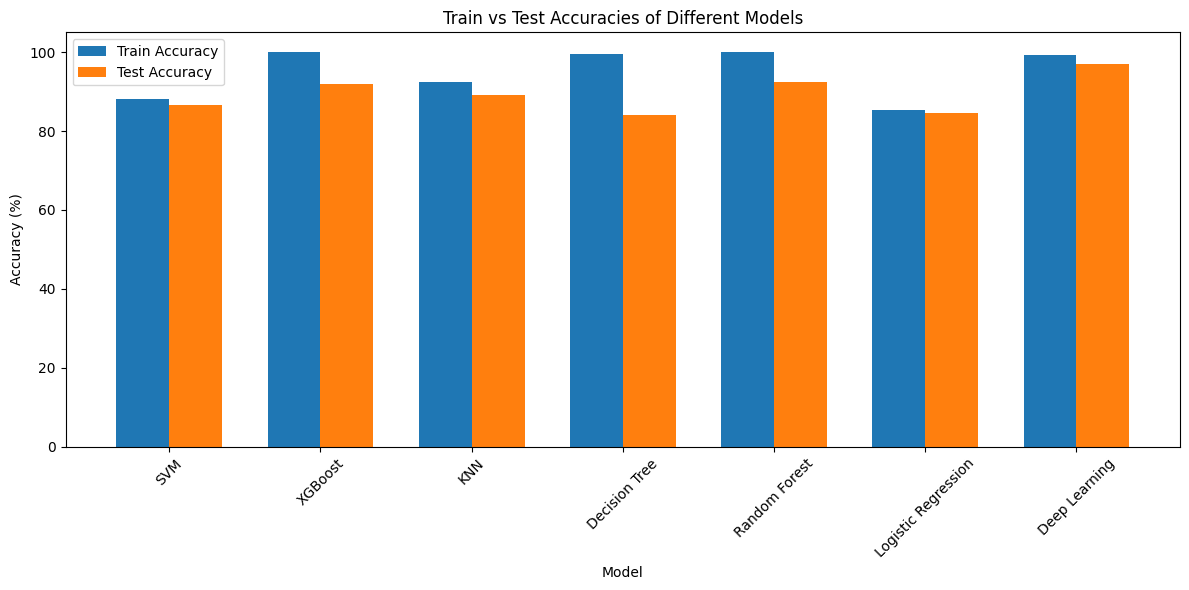

In [10]:
# Visualization of model accuracies
plt.figure(figsize=(12, 6))
train_accuracies = [accuracy[0] for accuracy in model_accuracies.values()]
test_accuracies = [accuracy[1] for accuracy in model_accuracies.values()]
bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_accuracies, bar_width, label='Train Accuracy')
plt.bar(index + bar_width, test_accuracies, bar_width, label='Test Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracies of Different Models')
plt.xticks(index + bar_width / 2, models.keys(), rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## III. Results and Analysis

The primary focus of this project was to optimize a Deep Learning model for the diagnosis of Parkinson's Disease (PD) using voice recordings and compare its performance with several traditional machine learning models. Bayesian Optimization was employed to fine-tune the hyperparameters of the Deep Learning model.

#### A. Optimizing Deep Learning Model
The optimization process involved adjusting three key hyperparameters: learning rate (lr), batch size, and epochs. The highest test accuracy achieved was 92.31% with the optimized parameters being a batch size of approximately 55.55, 98.42 epochs, and a learning rate of 0.0021. This optimization indicates the importance of fine-tuning in enhancing model performance, particularly in a complex task such as PD diagnosis through voice analysis.

#### B. Comparison with Traditional Machine Learning Models
To benchmark the performance of the optimized Deep Learning model, it was compared against several traditional machine learning algorithms:

- **SVM (Support Vector Machine)**: Exhibited a training accuracy of 88.21% and a testing accuracy of 86.67%.
- **XGBoost (eXtreme Gradient Boosting)**: Demonstrated perfect training accuracy (100%) and a testing accuracy of 91.79%.
- **KNN (K-Nearest Neighbors)**: Showed a training accuracy of 92.44% and a testing accuracy of 89.23%.
- **Decision Tree**: Yielded a high training accuracy of 99.49% but a lower testing accuracy of 84.10%.
- **Random Forest**: Matched XGBoost in training accuracy (100%) and achieved a testing accuracy of 92.31%.
- **Logistic Regression**: Produced a training accuracy of 85.38% and a testing accuracy of 84.62%.

#### C. Deep Learning Model Performance
The Deep Learning model, post-optimization, outperformed all other models with a remarkable training accuracy of 99.36% and a testing accuracy of 96.92%. This high level of performance underscores the effectiveness of neural networks in handling complex patterns in data, especially in biomedical applications.

#### D. Analysis
The results demonstrate the potential of machine learning, particularly Deep Learning, in medical diagnostics. The high accuracy achieved by the Deep Learning model suggests its viability as a tool for non-invasive PD diagnosis. However, the traditional models, particularly XGBoost and Random Forest, also performed admirably, indicating their usefulness in scenarios where deep learning might not be feasible.

The overfitting observed in some traditional models, as evidenced by perfect training accuracies but lower testing accuracies, highlights the importance of careful model selection and validation in medical applications. Moreover, the performance of the Deep Learning model emphasizes the value of hyperparameter optimization in achieving high accuracy.



## IV. Conclusion

This study has effectively illustrated the significant potential of machine-learning techniques in diagnosing Parkinson's Disease (PD) through the analysis of voice data. The standout performance of the optimized Deep Learning model, EnhancedNet, highlights the power of even relatively simple neural network architectures in extracting patterns and features from complex datasets like voice recordings. The model's ability to discern nuances in voice affected by PD could pave the way for more accurate and non-invasive diagnostic methods.

However, the results obtained from traditional machine learning models, such as SVM, XGBoost, and Random Forest, also reveal the value of a multi-faceted approach. These models, while perhaps less sophisticated than their deep learning counterparts, offer robustness, simplicity, and often greater interpretability. Their effectiveness in this context suggests that a combination of both traditional and advanced models could enhance diagnostic accuracy and reliability. This ensemble approach can leverage the strengths of various algorithms, potentially offering better performance than any single model.

Looking ahead, there are several avenues for further research and development:

1. **Integration of Larger and More Diverse Datasets**: Incorporating a broader range of voice data, including more diverse demographics and stages of PD, can improve the generalizability of the models. Larger datasets can also aid in fine-tuning deep learning models more effectively, reducing the risk of overfitting and improving their performance across varied populations.

2. **Exploring Model Combinations**: Future research could investigate how different models can be combined. Techniques like ensemble learning, where predictions from multiple models are combined, or hybrid models, which integrate aspects of both traditional and deep learning approaches, could be particularly fruitful.

3. **Clinical Application and Validation**: Applying these models in real-world clinical settings is a critical next step. Clinical validation involves testing the models with live patient data and in real diagnostic scenarios. This step is crucial for assessing the practical viability of the models and for making necessary adjustments to meet clinical standards.

4. **Focus on Interpretability and Explainability**: As machine learning models, particularly deep learning models, become more complex, ensuring their decisions are interpretable is crucial for clinical acceptance. Research in explainable AI could make these models more transparent and trustworthy to healthcare professionals.

5. **Ethical and Privacy Considerations**: With the increased use of personal data, such as voice recordings, ethical considerations and data privacy become increasingly important. Future research should include guidelines and measures to protect patient privacy and ensure ethical use of AI in healthcare.

In the end, while this study marks a step forward in using machine learning for PD diagnosis, these future research directions could further refine the technology, making it more accurate, reliable, and applicable in a clinical environment. The ultimate goal is to develop a tool that is not only technologically advanced but also ethically sound, easily interpretable, and widely accessible to healthcare providers and patients.

## V. References

Little, M. A., McSharry, P. E., Hunter, E. J., & Ramig, L. O. (2008). Suitability of dysphonia measurements for telemonitoring of Parkinson's disease. IEEE Transactions on Biomedical Engineering.

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... & Desmaison, A. (2019). PyTorch: An imperative style, high-performance deep learning library. In Advances in Neural Information Processing Systems (pp. 8026-8037).

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Dubourg, V. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825-2830.

Chen, T., & Guestrin, C. (2016). XGBoost: A scalable tree boosting system. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785-794).

Cover, T., & Hart, P. (1967). Nearest neighbor pattern classification. IEEE Transactions on Information Theory, 13(1), 21-27.

Breiman, L. (2001). Random forests. Machine Learning, 45(1), 5-32.

Hosmer Jr, D. W., Lemeshow, S., & Sturdivant, R. X. (2013). Applied logistic regression (Vol. 398). John Wiley & Sons.

Frazier, P. I. (2018). A tutorial on Bayesian optimization. arXiv preprint arXiv:1807.02811.